In [0]:
# !pip install tensorflow-gpu==1.15.0

In [0]:
# !pip install keras==2.0.8

In [0]:
# !pip install pydicom

In [8]:
import tensorflow as tf
import keras
import pydicom

print(tf.__version__)
print(keras.__version__)
print(tf.test.is_gpu_available())

1.15.0
2.0.8
True


In [9]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
cd gdrive/My Drive/Colab Notebooks/RSNA

/content/gdrive/My Drive/Colab Notebooks/RSNA


# RSNA Pneumonia Detection Challenge


## What is Pneumonia?
Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it.

The infection causes inflammation in the air sacs in your lungs, which are called alveoli. The alveoli fill with fluid or pus, making it difficult to breathe.

## The purpose of the challenge
The thing that we have to do is "Lung Opacities Detecteion". 

Lung opacities are vague, fuzzy clouds of white in the darkness of the lungs, which makes detecting them a real challenge.



**Normal vs. Lung Opacity images**

![picture](https://github.com/namyouth/RSNA-Pneumonia-Detection/blob/master/img/picture.png?raw=true)


### Quick Process

- Step 1: Clone the Mask R-CNN repository
- Step 2: Download the pre-trained weights for COCO model from MatterPort.
- Step 3: Import the required libraries
- Step 4: We Create a myMaskRCNNConfig class for training on the Kangaroo dataset. It is derived from the base Mask R-CNN Config class and overrides some values.
- Step 5: Build the custom kangaroo data set.
- Step 6: Prepare the train and test set
- Step 7 :Initialize Mask R-CNN model for “training” using the Config instance that we created
- Step 8: Load the pre-trained weights for the Mask R-CNN from COCO data set excluding the last few layers
- Step 9: Train the heads with higher learning rate to speed up the learning
- Step 10: Save the trained weights for custom data set
- Step 11: Detecting objects in the image with masks and bounding box from the trained model


In [0]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold

In [0]:
DATA_DIR = '/content/gdrive/My Drive/Colab Notebooks/RSNA/dataset'

ROOT_DIR = '/content/gdrive/My Drive/Colab Notebooks/RSNA'

## Step 1: Clone the Mask R-CNN repository


Install Matterport's Mask-RCNN model from github.

https://github.com/matterport/Mask_RCNN

In [13]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
#!python setup.py -q install

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


## Step 2: Download the pre-trained weights for COCO model from MatterPort.


In [14]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw------- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


## Step 3: Import the required libraries

In [0]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [0]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

Some setup functions and classes for Mask-RCNN
- dicom_fps is a list of the dicom image path and filenames
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [0]:
# dicom_dir = '/content/gdrive/My Drive/Colab Notebooks/RSNA/dataset/stage_2_train_images'

In [0]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

## Step 4: Create a DetectorConfig class for training on the Pneumonia dataset.

In [40]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 100
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

## Step 5: Build the custom dataset.

In [0]:
class DetectorDataset(utils.Dataset): 
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [81]:
detailed_info = pd.read_csv(os.path.join(ROOT_DIR, 'stage_2_detailed_class_info.csv'))
detailed_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


class info (30227, 2)
class info 30227
class 0        No Lung Opacity / Not Normal
1        No Lung Opacity / Not Normal
2        No Lung Opacity / Not Normal
3                              Normal
4                        Lung Opacity
                     ...             
30222                    Lung Opacity
30223                          Normal
30224                          Normal
30225                    Lung Opacity
30226                    Lung Opacity
Name: class, Length: 30227, dtype: object
------------------------------
patientId 26684
patientId 0        0004cfab-14fd-4e49-80ba-63a80b6bddd6
1        00313ee0-9eaa-42f4-b0ab-c148ed3241cd
2        00322d4d-1c29-4943-afc9-b6754be640eb
3        003d8fa0-6bf1-40ed-b54c-ac657f8495c5
4        00436515-870c-4b36-a041-de91049b9ab4
                         ...                 
30222    c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8
30223    c1edf42b-5958-47ff-a1e7-4f23d99583ba
30224    c1f6b555-2eb1-4231-98f6-50a963976431
30225    c1f7889a-9ea9-4

,patientId,class
23226,d1368bfd-8e96-4c4b-9c83-205fc4576b7b,No Lung Opacity / Not Normal
19033,b1d88801-a6c9-4ab1-9ded-a98a6973f56e,Normal
16289,9de81172-a002-46fc-b17c-8701f04c2647,Normal


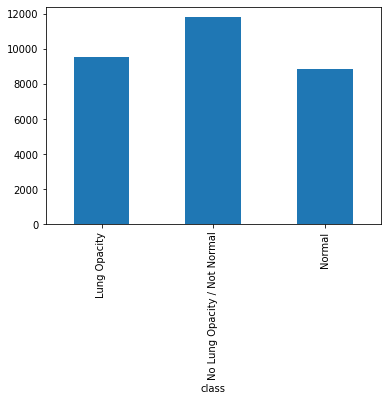

In [95]:
print('class info', detailed_info.shape)
print('class info', detailed_info.shape[0])
print('class', detailed_info['class'])
print('-'*30)
print('patientId', detailed_info['patientId'].value_counts().shape[0])
print('patientId', detailed_info['patientId'])

detailed_info.groupby('class').size().plot.bar()
detailed_info.sample(3)

Examine the annotation data, parse the dataset and view dicom fields

In [42]:
anns = pd.read_csv(os.path.join(ROOT_DIR, 'stage_2_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [0]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath
image = ds.pixel_array # get image array

In [45]:
# show dicom fields
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.12707.1517874367.136396
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: 'f0678ab1-7a59-46b9-ba2c-def9ad6b8d22'
(0010, 0020) Patient ID                          LO: 'f0678ab1-7a59-46b9-ba2c-def9ad6b8d22'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient'

In [0]:
# Original DICOM image size : 1024 x 1024
ORIG_SIZE = 1024

## Step 6: Split the train set, validation/test set

In [47]:
# Modify this line to use fewer images for training / validation.
image_fps_list = list(image_fps[:2000])

# split dataset into training vs. validation datast
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
# total_index = (1- 0.1) * 2000 
split_index = int((1 - validation_split) * len(image_fps_list)) 
print(split_index)
print(len(image_fps_list))

# split
image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))


1800
2000
1800 200


Let's look ata a sample annotation.

In [48]:
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [49]:
# Show annotations(s) for a DICOM image
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    28684a2f-1e6f-4431-969a-2f9cf574e7ba
 x                                             612
 y                                             611
 width                                         141
 height                                        146
 Target                                          1
 Name: 29879, dtype: object, patientId    28684a2f-1e6f-4431-969a-2f9cf574e7ba
 x                                              28
 y                                             507
 width                                         260
 height                                        347
 Target                                          1
 Name: 29880, dtype: object]

## Step 7: Prepare the train and test set

In [0]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [0]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

Display a random image with bounding boxes

(1024, 1024, 3)

class_ids --> [0]
class_ids --> 0
------------------------------
image[0:1] --> [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [2 2 2]
  [2 2 2]
  [1 1 1]]]
image.shape --> (1024, 1024, 3)
------------------------------
before) mask[0:1] --> [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]
after) masked[0:1] --> [[0. 0. 0. ... 0. 0. 0.]]
mask.shape --> (1024, 1024, 1)
------------------------------
image_fp --> /content/gdrive/My Drive/Colab Notebooks/RSNA/dataset/stage_2_train_images/89d63d9c-91be-49b1-a072-a4076a35a29b.dcm
image_id --> 859
------------------------------
dataset_train.image_ids --> [   0    1    2 ... 1797 1798 1799]
dataset_val.image_ids --> [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74

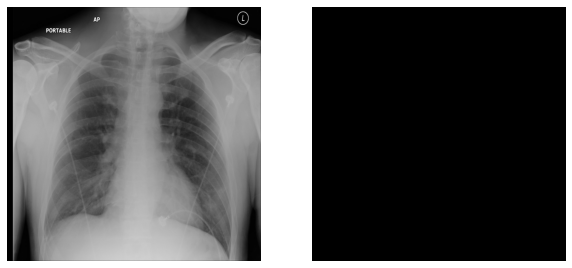

In [53]:
# Load and display random sample and their bounding boxes

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1,2,2)
masked = np.zeros(image.shape[:2])

############################
for i in range(mask.shape[2]):
    masked += image[:,:,0] * mask[:,:,i]
plt.imshow(masked, cmap='gray')
plt.axis('off')
############################

print('\nclass_ids -->', class_ids)
print('class_ids -->', class_ids[0])

print('-'*30)
print('image[0:1] -->',image[0:1])
print('image.shape -->', image.shape)

print('-'*30)
print('before) mask[0:1] -->',mask[0:1])
print('after) masked[0:1] -->', masked[0:1])
print('mask.shape -->', mask.shape)

print('-'*30)
print('image_fp -->', image_fp)
print('image_id -->', image_id)

print('-'*30)
print('dataset_train.image_ids -->', dataset_train.image_ids)
print('dataset_val.image_ids -->', dataset_val.image_ids)


## Step8: Image Augmentation
Try finetuning some variables to custom values

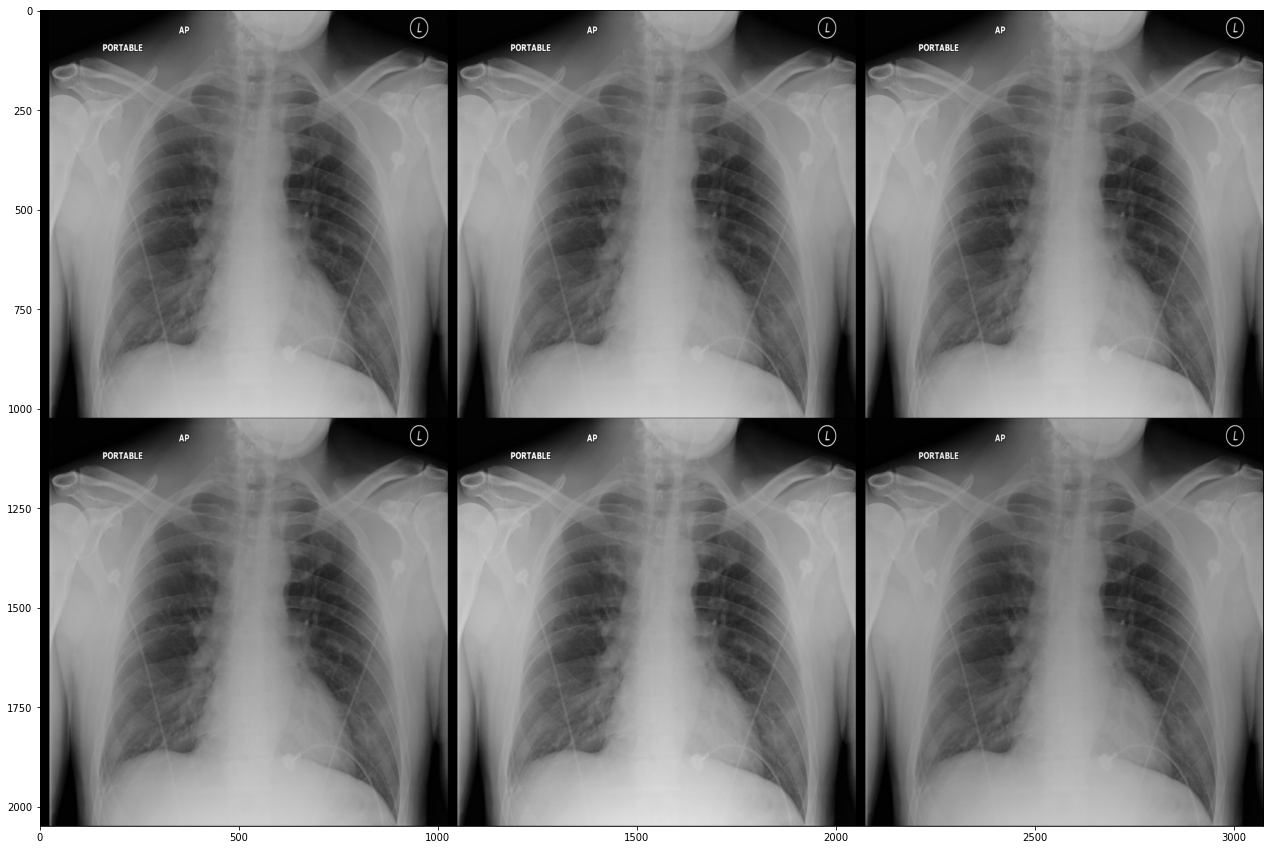

In [54]:
# image augmentation
augmentation = iaa.SomeOf((0,1), [
        iaa.Fliplr(0.5), 
        iaa.Affine(
            scale={'x':(0.8, 1.2), 'y': (0.8, 1.2)},
            translate_percent = {'x': (-0.2, 0.2), 'y': (-0.2, 0.2)},
            rotate = (-10, 10),
            shear = (-8, 8)
        ),
        iaa.Multiply((0.9, 1.1))
])

# test on the same image as above

imggrid = augmentation.draw_grid(image[:,:,0], cols=3, rows=2)
plt.figure(figsize=(30, 15))
_ = plt.imshow(imggrid[:,:,0], cmap='gray')

## Step 9 :Initialize Mask R-CNN model for “training” using the Config instance that we created

In [0]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

## Step 10: Load the pre-trained weights for the Mask R-CNN from COCO data set excluding the last few layers

In [60]:
# exclude the last layers because they require a matching number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [0]:
LEARNING_RATE = 0.006

# Train Mask RCNN Model
import warnings
warnings.filterwarnings('ignore')

## Step 11: Train the heads with higher learning rate to speed up the learning

In [62]:
model.train(dataset_train, dataset_val, 
            learning_rate=LEARNING_RATE*2, epochs=2, layers='heads', augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.012

Checkpoint Path: /content/gdrive/My Drive/Colab Notebooks/RSNA/pneumonia20200429T0706/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Ti

In [66]:
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE, epochs=6, layers='all', augmentation=augmentation)


Starting at epoch 6. LR=0.006

Checkpoint Path: /content/gdrive/My Drive/Colab Notebooks/RSNA/pneumonia20200429T0706/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b   

In [0]:
new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [68]:
epochs = range(1, len(next(iter(history.values()))) + 1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.867138,0.045373,0.472348,0.381802,0.524223,0.443389,2.097603,0.063465,0.517810,0.404962,0.585956,0.525408
2,1.858798,0.062575,0.481850,0.398020,0.522745,0.393605,1.779721,0.051729,0.523337,0.345485,0.464019,0.395147
3,1.583684,0.039070,0.424312,0.293832,0.439850,0.386611,1.624813,0.049043,0.454723,0.291130,0.438463,0.391445
4,1.703326,0.039811,0.513242,0.295872,0.462935,0.391456,1.499031,0.037314,0.412055,0.259586,0.406321,0.383745
5,1.928608,0.066133,0.788930,0.266958,0.411414,0.395163,1.376741,0.032342,0.382138,0.237339,0.355963,0.368950
6,1.713765,0.043930,0.493870,0.308776,0.458420,0.408758,1.291393,0.026455,0.357451,0.223781,0.326382,0.357314


In [69]:
best_epoch = np.argmin(history['val_loss'])
print('best epoch:', best_epoch + 1, history['val_loss'][best_epoch])

best epoch: 3 1.5836840319633483


## Step12: Select the trained model

In [70]:
# select trained model
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        'Could not find model directory under {}'.format(self.model_dir))
    
fps = []

# pick last directory
for d in dir_names:
    dir_name = os.path.join(model.model_dir, d)

    # findthe last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith('mask_rcnn'), checkpoints)
    checkpoints = sorted(checkpoints)

    if not checkpoints:
        print('No weigh files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /content/gdrive/My Drive/Colab Notebooks/RSNA/pneumonia20200429T0706/mask_rcnn_pneumonia_0002.h5


## Step13: Define InferenceConfig and Load trained weights

In [72]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', config=inference_config, model_dir=ROOT_DIR)

# Load trained weights
assert model_path != "", 'Provide path to trained weights'
print('loading weights from', model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
loading weights from /content/gdrive/My Drive/Colab Notebooks/RSNA/pneumonia20200429T0706/mask_rcnn_pneumonia_0002.h5
Re-starting from epoch 2


In [0]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

(256, 256, 3)

*** No instances to display *** 

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  225.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  121.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16320, 4)         min:   -0.70988  max:    1.58439  float32
(256, 256, 3)

*** No instances to display *** 

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16320, 4)         min:   -0.70988  max:    1.58439  float32
(256, 256, 3)

*** No instances to display *** 

Processing 1 images
image                    shape: (

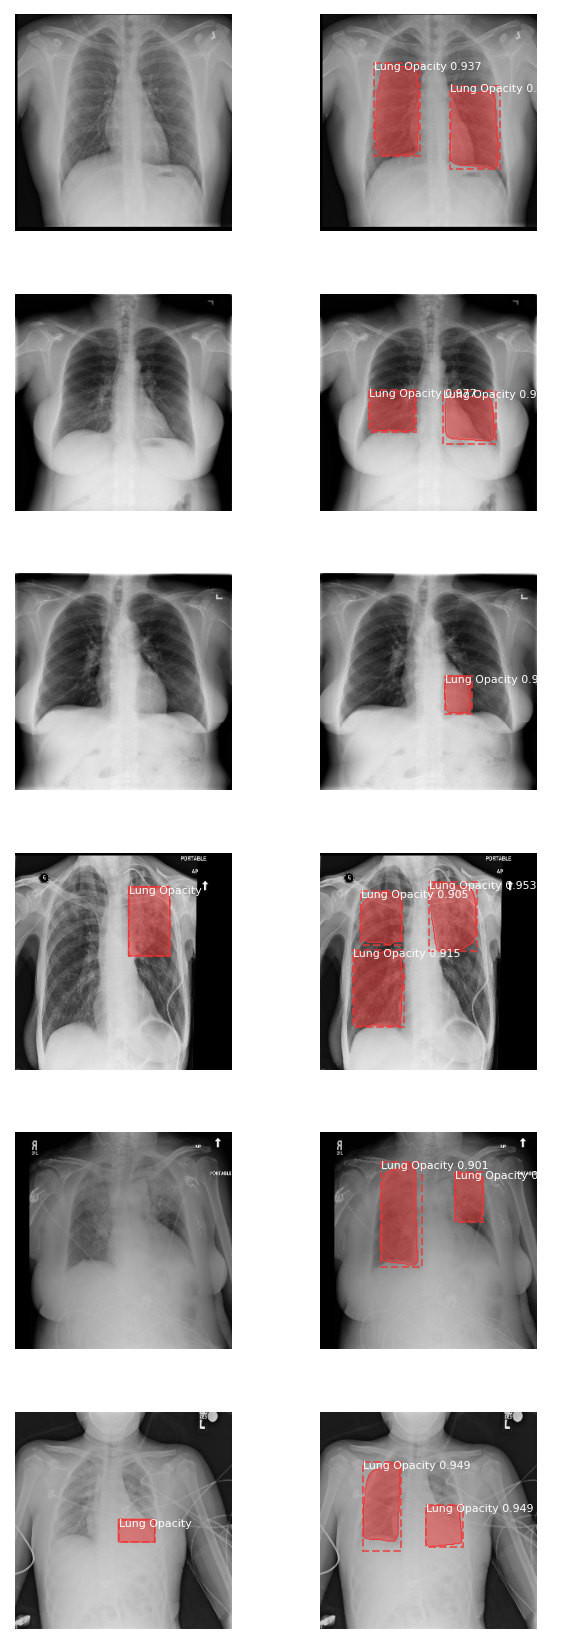

In [78]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)

    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)

    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                                dataset.class_names, colors=get_colors_for_class_ids(gt_class_id),ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image], verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                                dataset.class_names, r['scores'], colors=get_colors_for_class_ids(r['class_ids']),
                                ax=fig.axes[-1])    

In [0]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

### Reference
- https://www.kaggle.com/zahaviguy/what-are-lung-opacities
- https://www.kaggle.com/drt2290078/mask-rcnn-sample-starter-code
- https://www.kaggle.com/hmendonca/mask-rcnn-and-coco-transfer-learning-lb-0-155